In [1]:
%load_ext tensorboard
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd

# prep

In [2]:
SAMPLE_RATE = 22050

In [112]:
def load():
    """
    Load 10 second chunks of songs
    """

    files = list(Path("./data/").glob("*.mp3"))
    chunks = []
    for file in files:
        y, sr =  librosa.load(file, mono=True,sr=SAMPLE_RATE)
        size = int(SAMPLE_RATE * 10)
        sampleLen = len(y)
        
        for startPos in range(0,sampleLen,size):
            end = startPos+size
            if end > sampleLen:
                pass
            chunk = y[startPos:end]
            #chunk = librosa.effects.preemphasis(chunk) 
            chunks.append(chunk)
    return chunks

In [113]:
def dataset(chunks):
    x,y = [],[]
    size = int(SAMPLE_RATE*5)
    for chunk in chunks:
        Ax = chunk[:size]
        Ay = chunk[size:size*2]
        if(len(Ax) == size and len(Ay) == size):
            Ax = librosa.feature.melspectrogram(y=Ax, sr=SAMPLE_RATE)
            Ay = librosa.feature.melspectrogram(y=Ay, sr=SAMPLE_RATE)
            ma,mi = Ax.max(), Ax.min()
            Ax = (Ax - mi) / (ma - mi)
            
            ma,mi = Ay.max(), Ay.min()
            Ay = (Ay - mi) / (ma - mi)
            x.append(Ax)
            y.append(Ay)
    return x,y

In [5]:
def showSpec(spec):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=SAMPLE_RATE,
                             x_axis='time', y_axis='mel',
                             cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.show()

In [6]:
def playSpec(spec):
    S = librosa.feature.inverse.mel_to_stft(spec, sr=SAMPLE_RATE)
    audio = librosa.griffinlim(S,n_iter=25,momentum=0.99)
    audio = librosa.effects.preemphasis(audio)  # Reapply pre-emphasis

    plt.figure(figsize=(12,4))
    plt.plot(audio)
    plt.title('waveform')
    plt.show()

    display(ipd.Audio(audio,rate=SAMPLE_RATE))

# Load Data

In [7]:
chunks = load()

In [8]:
x,y = dataset(chunks)
print(len(x))

3385


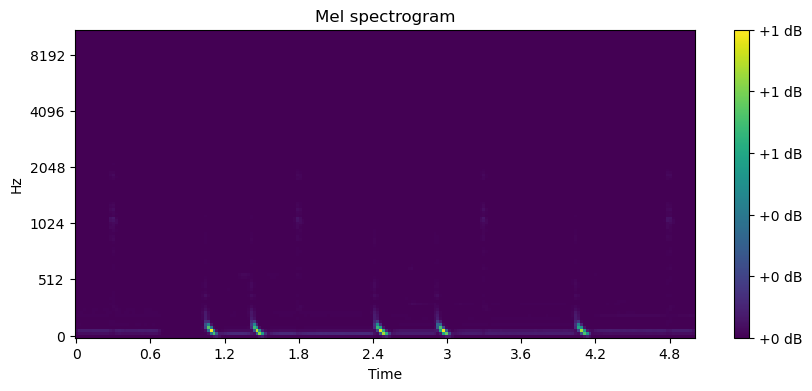

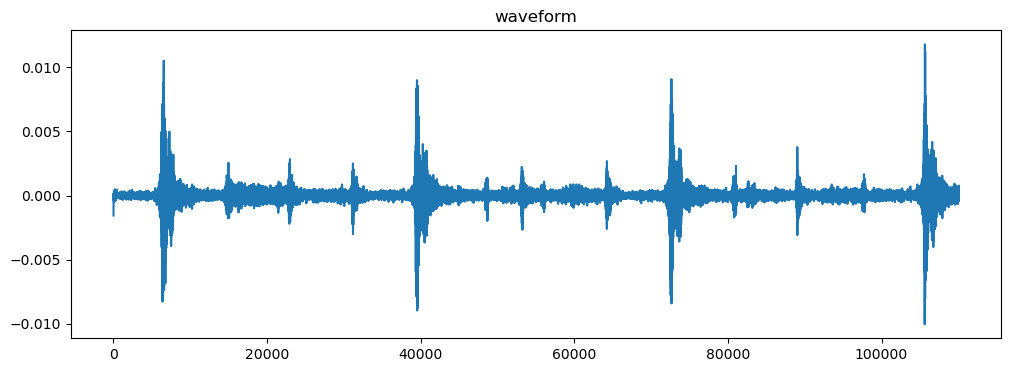

In [80]:
#verify loaded data
sample=x[420]
showSpec(sample)
playSpec(sample)

In [85]:
from tinygrad import TinyJit, Device, Tensor, nn
from tinygrad.nn.state import safe_save, get_state_dict
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
import model as m
import importlib
importlib.reload(m)
model = m.Model(latent_dim=16)
optimizer = nn.optim.AdamW(nn.state.get_parameters(model), lr=1e-4)

In [272]:
@TinyJit
def jit_step(X: Tensor, Y: Tensor,epoch) -> Tensor:
    Tensor.training = True
    optimizer.zero_grad()
    _, loss = model.__Lcall__(X,Y,epoch)
    loss.backward()
    optimizer.step()
    return loss.realize()


In [279]:
#_ = jit_step(Tensor(x[0]).reshape(1, 1, 128, 216), Tensor(y[0]).reshape(1, 1, 128, 216))
size = 200 #len(x)

x_np, y_np = np.stack(x), np.stack(y)
x_np = np.expand_dims(x_np, axis=1)
y_np = np.expand_dims(y_np, axis=1)
x_np.shape
BACH_SIZE=6
l=0

eshape = (BACH_SIZE, 1, 128, 216)
for e in range(0,12):
    print(f"\n--- Starting Epoch {e} rate of {l}---")
    l=0
    permutation = np.random.permutation(size)
    x_np = x_np[permutation]
    y_np = y_np[permutation]
    for i in range(0,size,BACH_SIZE):
        tx,ty=Tensor(x_np[i:i+BACH_SIZE]),Tensor(y_np[i:i+BACH_SIZE])
        if(tx.shape != eshape or ty.shape != eshape):
            continue
        l+=jit_step(tx,ty,e).numpy()
    l /= BACH_SIZE



--- Starting Epoch 0 rate of 0---

--- Starting Epoch 1 rate of 0.024080323055386543---

--- Starting Epoch 2 rate of 0.02331373281776905---

--- Starting Epoch 3 rate of 0.023173624649643898---

--- Starting Epoch 4 rate of 0.02290959469974041---

--- Starting Epoch 5 rate of 0.022660640999674797---

--- Starting Epoch 6 rate of 0.022699641063809395---

--- Starting Epoch 7 rate of 0.022513432428240776---


KeyboardInterrupt: 

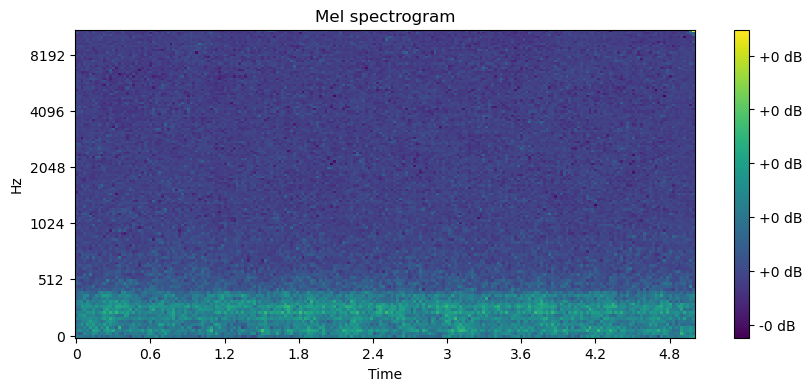

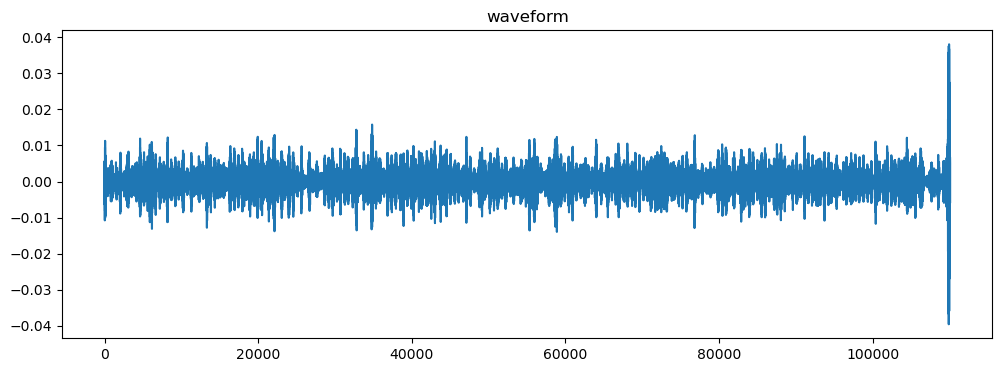

In [280]:
out = model(Tensor(x_np[40:41])).realize().numpy()[0][0]*5
#out = y[40]
showSpec(out)
playSpec(out)

In [ ]:
type(x[0])

In [ ]:
print(len(x))

In [163]:
x_np.min()

np.float32(0.0)